In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle5 as pickle
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

# mmfc 불러오기

In [3]:
with open("/content/drive/MyDrive/multi/second_project/data/mfcc_data/mfcc_1565_final.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)
result_data.shape

(2304, 30, 901)

## covid19 여부 불러오기



In [4]:
y = pd.read_csv("/content/drive/MyDrive/multi/second_project/data/mfcc_data/Y_data_1516.csv").iloc[:,0]


## feature 불러오기

In [5]:
features = pd.read_csv("/content/drive/MyDrive/multi/second_project/data/train_df_최종본_15세이상_65세미만.csv")
features = features.iloc[:,[4,5,6,7]]
feature_lst = []
for i in features.index:
    for _ in range(4):
        feature_lst.append(features.iloc[i,:].values)
features = pd.DataFrame(feature_lst)
features.shape

(2304, 4)

In [6]:
features.head(3)

,0,1,2,3
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, features, stratify = features, test_size = 0.2
)

In [8]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values

In [9]:
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [10]:
# 각 입력에 대한 형태를 명시
img_input = Input(shape = (30,901,1), name = "X_train")
form_input = Input(shape = (3,), name = "features_train")

In [11]:
# 이미지 입력
x_1 = Conv2D(64, (3,3), activation = "relu")(img_input)
x_1 = Conv2D(64, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(pool_size=(2,2),strides = 2)(x_1)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(pool_size=(2,2),strides = 2)(x_1)
x_1 = GlobalAveragePooling2D()(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Conv2D(32, (3,3), activation = "relu")(img_input)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(pool_size=(2,2),strides = 2)(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Dense(128, activation = "relu")(x_1)
x_1 = Dense(64, activation = "relu")(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Flatten()(x_1)


# 피쳐 입력
x_2 = Dense(128, input_dim = 3 ,activation  = "relu")(form_input)
x_2 = Dense(64, activation = "relu")(x_2)
x_2 = Dense(32, activation = "relu")(x_2)

In [12]:
# 출력을 만들기 위해 모든 입력을 하나의 텐서로 합침
x = Concatenate()([x_1, x_2])

In [13]:
rate_pred = Dense(1, name = "covid", activation = "sigmoid")(x)

In [14]:
model = Model(inputs = [img_input, form_input],
              outputs = [rate_pred])

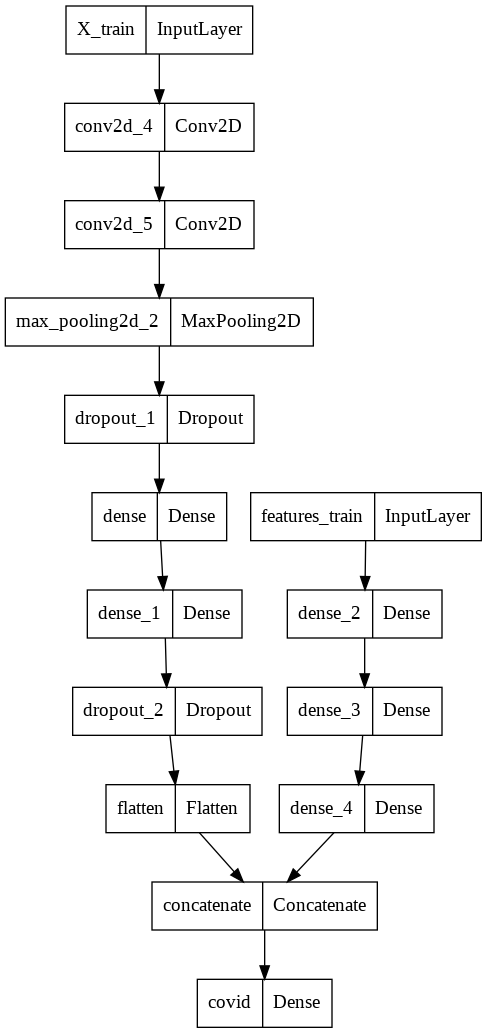

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 30, 901, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 899, 32)  320         ['X_train[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 26, 897, 32)  9248        ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 448, 32)  0          ['conv2d_5[0][0]']           

In [17]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy", metrics = ["accuracy"])

In [18]:
model_path = "second-functional.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1, monitor = "val_loss")
es = EarlyStopping(patience=10, monitor = "val_loss")

In [19]:
hist = model.fit([X_train, features_train] , y_data_train,
                 epochs = 100, batch_size = 100,
                 validation_split=0.2, callbacks = [mc,es])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 24.4688 - accuracy: 0.5237
Epoch 1: val_loss improved from inf to 2.43160, saving model to second-functional.h5
15/15 [==============================] - 8s 316ms/step - loss: 24.4688 - accuracy: 0.5237 - val_loss: 2.4316 - val_accuracy: 0.4715
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 1.0663 - accuracy: 0.5251
Epoch 2: val_loss improved from 2.43160 to 0.71332, saving model to second-functional.h5
15/15 [==============================] - 3s 203ms/step - loss: 1.0663 - accuracy: 0.5251 - val_loss: 0.7133 - val_accuracy: 0.5257
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5706
Epoch 3: val_loss improved from 0.71332 to 0.68499, saving model to second-functional.h5
15/15 [==============================] - 3s 212ms/step - loss: 0.6802 - accuracy: 0.5706 - val_loss: 0.6850 - val_accuracy: 0.5827
Epoch 4/100
15/15 [==============================] - ETA:

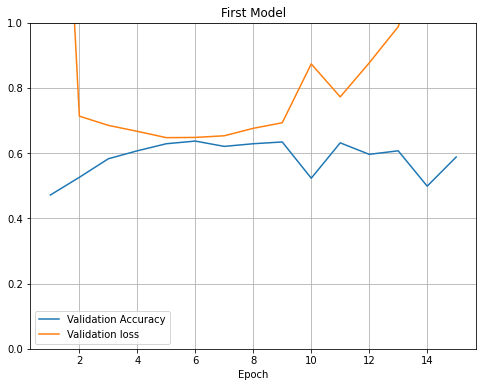

In [20]:
y_acc = hist.history["val_accuracy"]
y_vloss = hist.history["val_loss"]
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (8,6))
plt.plot(xs, y_acc, label = "Validation Accuracy")
plt.plot(xs, y_vloss, label = "Validation loss")
plt.legend(), plt.grid(), plt.xlabel("Epoch"), plt.title("First Model"), plt.ylim([0,1])
plt.show()

In [21]:
model = load_model(model_path)
model.evaluate([X_test, features_test], y_data_test)

15/15 [==============================] - 1s 26ms/step - loss: 0.6531 - accuracy: 0.6182


[0.6530627608299255, 0.6182212829589844]